In [2]:
from google.colab import drive
drive.mount('/content/drive')
!pwd
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content
drive  sample_data


# Import libraries


In [3]:
!pip install torch-kmeans
import numpy as np
import json
import os
from matplotlib import pyplot as plt
from torch.utils.data import Dataset,DataLoader
import cv2
import torch
from torch_kmeans import KMeans
from torch import nn
import random
%matplotlib inline

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using {device} device")
!nvidia-smi

Using cuda device
Sat Oct  5 06:48:45 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8               9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+-------

# Load the data folder

In [4]:
DIR = './drive/MyDrive'
DATASET_FOLDER = 'CabongCachienDataset_COCO'
JSON_PATH = 'result.json'
json_file_path = os.path.join(DIR,DATASET_FOLDER,JSON_PATH)
dataset_path = os.path.join(DIR,DATASET_FOLDER)
json_file = open(json_file_path,"r")
strDict = json_file.read()
dataDict = json.loads(strDict)
annoDictList = dataDict['annotations']
imgDictList = dataDict['images']
print("Dataset Length:", len(annoDictList))
print("Number of images:", len(imgDictList))

Dataset Length: 499
Number of images: 459


# Process images

In [5]:
IMG_SIZE = (100, 50)
IMG_SIZE_TENSOR = (IMG_SIZE[1],IMG_SIZE[0])
FRAGMENTS = [0,0.5,0.5]

def crop_Resize(bbox,img,frag = FRAGMENTS):
    x, y, w, h = [ int(t) for t in bbox]
    img = img[y : (y + h), x : (x + w)]
    img = cv2.resize(img, IMG_SIZE)
    #change it to one channel
    new_vector = img[:,:,0] * frag[0] + img[:,:,1] * frag[1] + img[:,:,2] * frag[2]
    return new_vector

# Define Dataset class

In [7]:
class CocoData(Dataset):
    def __init__(self,imgList,annoList,fr=FRAGMENTS):
        self.x = torch.zeros((len(annoList),IMG_SIZE[0] * IMG_SIZE[1]),device=device)
        self.y = torch.zeros(len(annoList),device=device)
        for i,dict in enumerate(annoList):
            img_id = dict['image_id']
            bbox = dict['bbox']
            temp = imgList[img_id]['file_name']
            img_path = os.path.join(dataset_path,temp)
            img_oj = cv2.imread(img_path)
            img = crop_Resize(bbox,img_oj,frag = fr)
            tempX = torch.tensor(img)
            self.x[i, :] = (torch.flatten(tempX))
            self.y[i] = dict['category_id']
            self.x = nn.functional.normalize(self.x,dim = 1)
    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, index):
        return self.x[index, :], self.y[index]

TRAINING_DATA_END_POINT = 400
Shuf = True

if Shuf:
  random.shuffle(annoDictList)
training_data = CocoData(imgDictList,annoDictList[:TRAINING_DATA_END_POINT])
test_data = CocoData(imgDictList,annoDictList[TRAINING_DATA_END_POINT:])

# Try K - Means


In [8]:
kmeans_train = DataLoader(dataset=training_data,batch_size=len(training_data),shuffle = True)
kmeans_model = KMeans(n_clusters=2)
x,y = next(iter(kmeans_train))
x = x.view((1,len(training_data),IMG_SIZE[0]*IMG_SIZE[1]))
model = kmeans_model.fit(x)
y_hat = model.predict(x)
accuracy = (((y == y_hat).sum())/len(training_data)).item()
reverse_predict = False
if accuracy < 1 - accuracy:
    reverse_predict = True
    accuracy = 1 - accuracy
print("Accuracy (K-Means - Train):",accuracy)




kmeans_test = DataLoader(dataset=test_data,batch_size=len(test_data),shuffle = True)
x,y = next(iter(kmeans_test))
x = x.view((1,len(test_data),IMG_SIZE[0]*IMG_SIZE[1]))
y_hat = model.predict(x)
accuracy = (((y == y_hat).sum())/len(test_data)).item()
if reverse_predict:
    y_hat = 1 - y_hat
    accuracy = 1 - accuracy
print("Accuracy (K-Means - Test):",accuracy)

Full batch converged at iteration 8/100 with center shifts = tensor([0.], device='cuda:0').
Accuracy (K-Means - Train): 0.8624999523162842
Accuracy (K-Means - Test): 0.868686854839325


# Fine tune the FRAGMENTS params

Full batch converged at iteration 9/100 with center shifts = tensor([0.], device='cuda:0').
Full batch converged at iteration 9/100 with center shifts = tensor([0.], device='cuda:0').
Full batch converged at iteration 9/100 with center shifts = tensor([0.], device='cuda:0').
Full batch converged at iteration 9/100 with center shifts = tensor([0.], device='cuda:0').
Full batch converged at iteration 9/100 with center shifts = tensor([0.], device='cuda:0').
Full batch converged at iteration 9/100 with center shifts = tensor([0.], device='cuda:0').
Full batch converged at iteration 9/100 with center shifts = tensor([0.], device='cuda:0').
Full batch converged at iteration 9/100 with center shifts = tensor([0.], device='cuda:0').
Full batch converged at iteration 9/100 with center shifts = tensor([0.], device='cuda:0').
Full batch converged at iteration 9/100 with center shifts = tensor([0.], device='cuda:0').
Full batch converged at iteration 9/100 with center shifts = tensor([0.], device

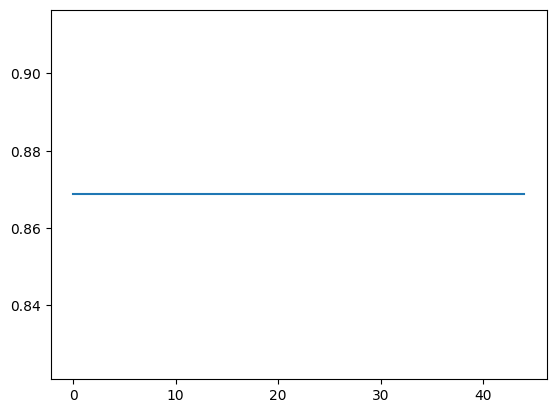

K-Means best training accuracy: 0.8686868697404861
given by fragment: [0.0, 0.0, 1.0]


In [9]:
def findFrag(iterations):
    accu = []
    maxaccu = 0.5
    maxlist = [0.25,0.25,0.5]
    for i in range(iterations):
        for j in range(iterations - 1 - i):
            a = i/iterations
            b = j/iterations
            c = 1 - a - b
            tData = DataLoader(training_data,batch_size=len(training_data))
            x,y = next(iter(tData))
            x = x.view((1,len(training_data),IMG_SIZE[0]*IMG_SIZE[1]))
            model = kmeans_model.fit(x)

            kmeans_test = DataLoader(dataset=test_data,batch_size=len(test_data))
            x,y = next(iter(kmeans_test))
            x = x.view((1,len(test_data),IMG_SIZE[0]*IMG_SIZE[1]))
            y_hat = model.predict(x)
            accuracy = (((y == y_hat).sum())/len(test_data)).item()
            reverse_predict = False
            if accuracy < 1 - accuracy:
                reverse_predict = True
                accuracy = 1 - accuracy
            accu.append(accuracy)
            if (maxaccu < accuracy ):
                maxaccu = accuracy
                maxlist = [a,b,c]
    return accu, maxaccu, maxlist

A,maxA,frags = findFrag(10)
plt.plot(A)
plt.show()
print("K-Means best training accuracy:",maxA)
print("given by fragment:", frags)

# Define Logistic Regression Model


In [18]:
class LogisticModel(nn.Module):
    def __init__(self,i):
        super().__init__()
        self.ln = nn.Linear(i,1,device=device)
        self.sm = nn.Sigmoid()
    def forward(self,x):
        x = self.ln(x.reshape(-1,x.shape[1]))
        x = self.sm(x)
        return x

criterion = nn.BCELoss()
model = LogisticModel(IMG_SIZE[0]*IMG_SIZE[1])
learning_rate = 0.7
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
new_train = DataLoader(training_data,batch_size=50,shuffle=True)
valid_data = DataLoader(test_data,shuffle = True)

def training_logistic(epochs):
    LOSS = []
    for epoch in range(epochs):
        total_loss = 0
        for x,y in new_train:
            optimizer.zero_grad()
            y_hat = model(x)
            y = y.view(-1, 1)
            loss = criterion(y_hat,y)
            loss.backward()
            optimizer.step()
            total_loss+= loss.item()
        LOSS.append(total_loss/len(training_data))
    return LOSS


#Train Logistic Model and Show the result

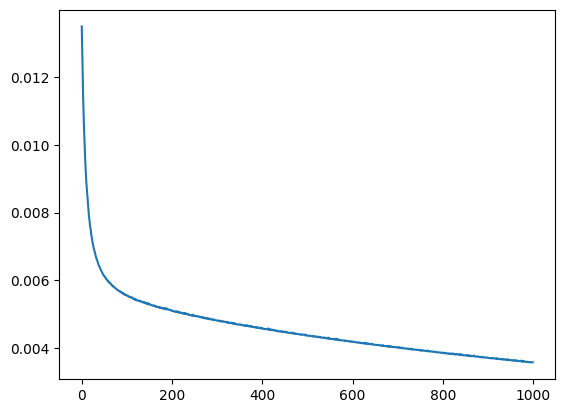

Accuracy (Logistic - Train): 0.9424999952316284
Accuracy (Logistic - Test): 0.9292929172515869


In [19]:
epochs = 1000
L = training_logistic(epochs)
plt.plot(L)
plt.show()

thres = 0.5
with torch.no_grad():
    x,y = training_data[:]
    y = y.view(-1, 1)
    y_hat = model(x)
    y_hat = torch.where(y_hat > thres, 1,0)
    ac = ((y==y_hat).sum()/(y.shape[0])).item()
print("Accuracy (Logistic - Train):", ac)

with torch.no_grad():
    x,y = test_data[:]
    y = y.view(-1, 1)
    y_hat = model(x)
    y_hat = torch.where(y_hat > thres, 1,0)
    ac = ((y==y_hat).sum()/(y.shape[0])).item()
print("Accuracy (Logistic - Test):", ac)